In [ ]:
using ITensors, ITensorMPS
using Plots
using Random
using Statistics
using LinearAlgebra



"I HAVENT TESTED THIS YET, THIS IS HERE TO PRODUCE GRAPH FIGURE 8 FROM THE REPORT\n\n\n"

In [27]:
"""
Creates a random MPS for a spin-1/2 chain of length L.
The initial state is antiferromagnetic, which helps DMRG converge.
"""
function create_MPS(L::Int)
    sites = siteinds("S=1/2", L; conserve_qns=true)
    initial_state = [isodd(i) ? "Up" : "Dn" for i in 1:L]
    ψ₀ = randomMPS(sites, initial_state)
    return ψ₀, sites
end

create_MPS

In [28]:
"""
Creates a weighted adjacency matrix
"""
function create_weighted_adj_mat(N::Int, σ::Float64; μ::Float64=1.0)
    if σ == 0.0
        A = ones(Float64, N, N)
        A -= Matrix{Float64}(I, N, N)
        return A
    end

    A = zeros(Float64, N, N)
    for i in 1:N, j in (i+1):N
        weight = μ + σ * randn()
        A[i, j] = A[j, i] = weight
    end
    return A
end

create_weighted_adj_mat

In [29]:
"""
Creates a weighted adjacency matrix
"""
function create_weighted_adj_mat(N::Int, σ::Float64; μ::Float64=1.0)
    if σ == 0.0
        A = ones(Float64, N, N)
        A -= Matrix{Float64}(I, N, N)
        return A
    end

    A = zeros(Float64, N, N)
    for i in 1:N, j in (i+1):N
        weight = μ + σ * randn()
        A[i, j] = A[j, i] = weight
    end
    return A
end

create_weighted_adj_mat

In [30]:
"""
Creates the MPO for the XXZ Hamiltonian on a graph with weighted interactions.
"""
function create_weighted_xxz_mpo(N::Int, adj_mat, sites; J::Float64=1.0, Δ::Float64=1.0)
    ampo = OpSum()
    for i in 1:N-1
        for j in i+1:N
            coupling_strength = adj_mat[i, j]
            if coupling_strength != 0.0
                ampo += coupling_strength * (J / 2), "S+", i, "S-", j
                ampo += coupling_strength * (J / 2), "S-", i, "S+", j
                ampo += coupling_strength * (J * Δ), "Sz", i, "Sz", j
            end
        end
    end
    return MPO(ampo, sites)
end

create_weighted_xxz_mpo

In [31]:
function plot_bond_dim()
    N_range = 10:1:75
    num_sweeps = 30
    max_bond_dim = 200
    cutoff = 1E-10
    σ = 0.0

    bond_dims = Float64[]

    for N in N_range
        ψ₀, sites = create_MPS(N) 
        adj_mat = create_weighted_adj_mat(N, σ)

        H_mpo = create_weighted_xxz_mpo(N, adj_mat, sites; J=-0.5, Δ=0.5)

        sweeps = Sweeps(num_sweeps)
        setmaxdim!(sweeps, max_bond_dim)
        setcutoff!(sweeps, cutoff)

        energy, ψ_gs = dmrg(H_mpo, ψ₀, sweeps; outputlevel=0)
        
        final_bond_dim = maxlinkdim(ψ_gs)
        push!(bond_dims, final_bond_dim)

        println("Completed N = $N. Energy = $(round(energy, digits=4)), Max Bond Dim = $final_bond_dim")
    end

    plt = plot(
        title="Saturated Bond Dimension for an Average Graph with N Nodes",
        xlabel="Number of Nodes",
        ylabel="Average Bond Dimension Required",
        legend=false,
        gridalpha=0.3,
        framestyle=:box
    )

    plot!(plt, N_range, bond_dims,
        lw=2,
        marker=:circle,
        markersize=4,
        markerstrokecolor=:auto,
        markercolor=:coral,
        linecolor=:deepskyblue
    )
    
    ylims!(plt, 0, ceil(Int, maximum(bond_dims))+1)

    return plt
end

plot_bond_dim (generic function with 1 method)

In [32]:
# plt = plot_bond_dim();
# display(plt)

In [33]:
N_range = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
energies00 = [-5.9375, -7.1875, -8.625, -10.125, -11.8125, -13.5625, -15.5, -17.5, -19.6875, -21.9375, -24.375, -26.875, -29.5625, -32.3125, -35.25, -38.25, -41.4375, -44.6875, -48.125, -51.625, -55.3125, -59.0625, -63.0, -67.0, -71.1875, -75.4375, -79.875, -84.375, -89.0625, -93.8125, -98.75, -103.75, -108.9375, -114.1875, -119.625, -125.125, -130.8125, -136.5625, -142.5, -148.5, -154.6875, -160.9375, -167.375, -173.875, -180.5625, -187.3125, -194.25, -201.25, -208.4375, -215.6875, -223.125, -230.625, -238.3125, -246.0625, -254.0, -262.0, -270.1875, -278.4375, -286.875, -295.375, -304.0625, -312.8125, -321.75, -330.75, -339.9375, -349.1875]
bond_dimensions00 = [6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 18, 19, 19, 20, 19, 20, 20, 21, 20, 21, 21, 22, 21, 22, 22, 23, 22, 23, 23, 24, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 25, 26, 26, 26, 26, 27, 26, 27, 27]

66-element Vector{Int64}:
  6
  6
  7
  7
  8
  8
  9
  9
 10
 10
 11
 11
 12
  ⋮
 25
 25
 26
 25
 26
 26
 26
 26
 27
 26
 27
 27

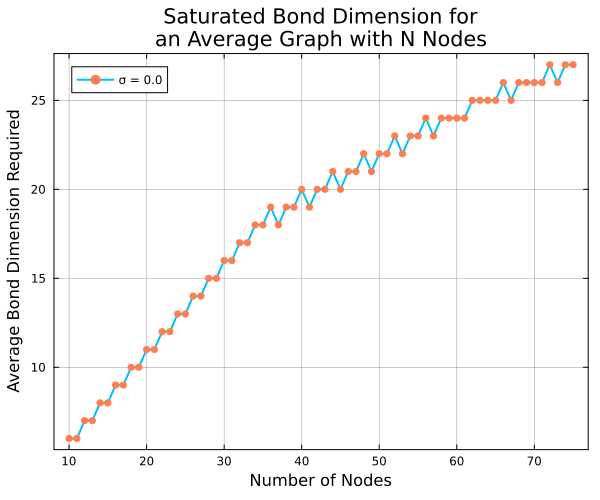

In [42]:
"""
alternative method of making the title appear correctly
using Plots.Measures # Add this to the top of your script

plot(
    # ... your data ...
    title="My Long Title\nOn Two Lines",
    top_margin=10mm # Adds 10 millimeters of space at the top
)
"""
    
    plt = plot(
        size=(600, 500), # default is 600, 400
        title="Saturated Bond Dimension for\nan Average Graph with N Nodes",
        xlabel="Number of Nodes",
        ylabel="Average Bond Dimension Required",
        legend=true,
        gridalpha=0.2,
        framestyle=:box
    )

    plot!(plt, N_range, bond_dimensions00,
        label="σ = 0.0",
        lw=2,
        marker=:circle,
        markersize=4,
        markerstrokecolor=:auto,
        markercolor=:coral,
        linecolor=:deepskyblue
    )